In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install seaborn --upgrade

     |████████████████████████████████| 283 kB 585 kB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.1f}'.format  # 1 decimal only for float numbers display
np.set_printoptions(suppress=True)

In [22]:
sales = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv", parse_dates=['date'])
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")

In [23]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.0,1.0
1,2013-03-01,0,25,2552,899.0,1.0
2,2013-05-01,0,25,2552,899.0,-1.0
3,2013-06-01,0,25,2554,1709.0,1.0
4,2013-01-15,0,25,2555,1099.0,1.0


Here we make a join to join sales_train with shops, items and item categories DataFrames so we can get all the dsata we are looking for in the same DataFrame.

In [24]:
sales_train = sales.join(other=shops, on="shop_id", how="inner", rsuffix="_").join(items, on="item_id", how="inner", rsuffix="_").join(categories, on="item_category_id", how="inner", rsuffix="_")
sales_train.drop(['shop_id_', 'item_id_', 'item_category_id_'], axis=1, inplace=True)

## EDA

In [25]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,2013-02-01,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
25918,2013-02-01,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
25919,2013-03-01,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
25920,2013-01-20,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
25921,2013-01-23,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


In [26]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2896865
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   shop_name           object        
 7   item_name           object        
 8   item_category_id    int64         
 9   item_category_name  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 246.4+ MB


In [27]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.0,2935849.0,2935849.0,2935849.0,2935849.0,2935849.0
mean,14.6,33.0,10197.2,890.9,1.2,40.0
std,9.4,16.2,6324.3,1729.8,2.6,17.1
min,0.0,0.0,0.0,-1.0,-22.0,0.0
25%,7.0,22.0,4476.0,249.0,1.0,28.0
50%,14.0,31.0,9343.0,399.0,1.0,40.0
75%,23.0,47.0,15684.0,999.0,1.0,55.0
max,33.0,59.0,22169.0,307980.0,2169.0,83.0


In [28]:
len(sales_train[sales_train['item_cnt_day']< 0])

7356

Here we can observe that some item_cnt_day values are negative. It seems that when an item is returned to the shop by a customer, a new row is created with a negative count to compensate for adding the item count when the customer first bought it. For the moment, we will just remove those rows from the DataFrame.

In [29]:
sales_train = sales_train[(sales_train['item_cnt_day'] > 0) & (sales_train['item_price'] > 0)]
sales_train.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

Here we want to remove item_cnt_day outliers from our data. We inspect the scatter plot and print somes percentiles to decide which threshold we should use to remove data.

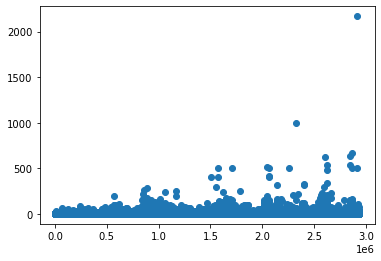

In [30]:
plt.scatter(sales_train.index, sales_train['item_cnt_day'])
plt.show()

### Percentile: 
It is a measure used in statistics indicating the value below which a given percentage of observations in a group of observations falls. For example the 20th percentile is the value (or score) below which 20% of the observation may be found.

In [31]:
p = 99
percentile= np.percentile(sales_train['item_cnt_day'], p)
print(f"The item_cnt_day {p}the percentile is equal to {percentile}")

The item_cnt_day 99the percentile is equal to 5.0


It means that 99% of item_cnt_day values are less or equal to 5 (so lies between 0 and 5)

In [32]:
outliers_num = len(sales_train[sales_train['item_cnt_day'] > percentile])
sales_train = sales_train[sales_train['item_cnt_day'] < percentile]
print(f"We removed {outliers_num} outliers from the data")

We removed 27411 outliers from the data


In [34]:
print(sales_train['item_id'].nunique())
print(sales_train['shop_id'].nunique())
print(len(test))

21794
60
214200


There is potentially 21807 x 60 (shop_id, item_id) combinations so 1 308 420 different combinations and that is pretty huge. Hopefully, we only need to forecast the combinations in the test file (214 200 combinations) and we also have to keep in mind that not all items are in all shops.

In [35]:
print(f"Min date from train set: {sales_train['date'].min().date()}")
print(f"Max date from train set: {sales_train['date'].max().date()}")

sales_train['month'] = sales_train['date'].dt.month
sales_train['year'] = sales_train['date'].dt.year

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


### What are the 15 most sold items?

In [ ]:
N = 15
items_total_sold = sales_train.groupby('item_id').sum()
items_total_sold.reset_index(inplace=True)

idx = items_total_sold['item_cnt_day'].values.argsort()[::=1][0:N]